# Debugging the Bottleneck Model in Detail

## Importing stuff

In [5]:
%load_ext autoreload
%autoreload 2
import sys
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os
import json
from collections import OrderedDict
import moments
import dadi
sys.path.append("/sietch_colab/akapoor/Demographic_Inference/")

In [6]:
experiment_config_filepath = '/sietch_colab/akapoor/Demographic_Inference/experiment_config.json'

## Step 1: Simulation

In [7]:
from snakemake_scripts.single_simulation import main

In [8]:
sim_directory = '/sietch_colab/akapoor/Demographic_Inference/simulated_parameters_and_inferences'
sim_number = 0

In [ ]:
main(experiment_config_filepath, sim_directory, sim_number)

Let's examine the contents

In [10]:
with open(f'{sim_directory}/simulation_results/sampled_params_{sim_number}.pkl', 'rb') as f:
    sampled_params = pickle.load(f)

In [11]:
sampled_params

{'N0': 15609,
 'Nb': 607,
 'N_recover': 22459,
 't_bottleneck_start': 2334,
 't_bottleneck_end': 354}

## Step 2: Genome Window VCFs

In [12]:
from snakemake_scripts.obtain_genome_vcfs import main as main_genome_vcf

In [ ]:
#tree_sequence_file, experiment_config_filepath, genome_sim_directory, window_number, sim_number

tree_sequence_file = f'/sietch_colab/akapoor/Demographic_Inference/sims/simulation_results/ts_sim_{sim_number}.trees'
genome_sim_directory = '/sietch_colab/akapoor/Demographic_Inference/genome_windows_test'

for window_number in tqdm(range(100)):
    main_genome_vcf(tree_sequence_file, experiment_config_filepath, genome_sim_directory, window_number, sim_number)


## Step 3: LD Stats

In [ ]:
# ld_stat_creation(vcf_filepath, flat_map_path, pop_file_path, sim_directory, sim_number, window_number)

In [ ]:
from snakemake_scripts.ld_stats import ld_stat_creation

In [ ]:
sim_directory = '/sietch_colab/akapoor/Demographic_Inference/ld_stats_test'
for window_number in tqdm(range(100)):
    vcf_filepath = f'/sietch_colab/akapoor/Demographic_Inference/genome_windows_test/window_{window_number}/window.{window_number}.vcf.gz'
    flat_map_path = f'/sietch_colab/akapoor/Demographic_Inference/genome_windows_test/window_{window_number}/flat_map.txt'
    pop_file_path = f'/sietch_colab/akapoor/Demographic_Inference/genome_windows_test/window_{window_number}/samples.txt'
    ld_stat_creation(vcf_filepath, flat_map_path, pop_file_path, sim_directory, sim_number, window_number)
    

### Step 3.1: Gather the LD stats

In [ ]:
BASE_DIR = '/sietch_colab/akapoor/Demographic_Inference'

def gather_ld_stats(sim_number, experiment_config):
    """
    Collects and combines LD statistics for a given simulation number.

    Args:
        sim_number (int): Simulation number to process.
        experiment_config (dict): Configuration containing the number of windows.

    Saves:
        A combined pickle file for all windows in the given simulation.
    """
    # Define input file paths
    ld_stats_files = [
        os.path.join(BASE_DIR, f"ld_stats_test/sim_{sim_number}/window_{window_number}/ld_stats_window.{window_number}.pkl")
        for window_number in range(experiment_config["num_windows"])
    ]

    # Ensure output directory exists
    output_dir = os.path.join(BASE_DIR, f"combined_LD_inferences_test/sim_{sim_number}")
    os.makedirs(output_dir, exist_ok=True)

    # Output file path
    output_file = os.path.join(output_dir, f"combined_LD_stats_sim_{sim_number}.pkl")

    # Initialize combined dictionary
    combined_data = {}

    # Collect and merge LD statistics from all window files
    for window_number, file in enumerate(ld_stats_files):
        if os.path.exists(file):  # Ensure file exists before loading
            with open(file, "rb") as f:
                data = pickle.load(f)  # Expecting a dictionary per file

                if not isinstance(data, dict):
                    print(f"Warning: {file} does not contain a dictionary, skipping.")
                    continue  # Skip files that are not dicts

                # Ensure window index is preserved
                combined_data[window_number] = data

    # Save combined data in correct format
    with open(output_file, "wb") as f:
        pickle.dump(combined_data, f)

    print(f"Successfully saved combined LD statistics to {output_file}")

In [ ]:
with open(experiment_config_filepath, "r") as f:
    experiment_config = json.load(f)
    
gather_ld_stats(sim_number, experiment_config)

## Step 4: MomentsLD Inference

In [ ]:
from snakemake_scripts.momentsLD_analysis import main as momentsLD_func

In [ ]:
experiment_config_filepath

In [ ]:
combined_ld_stats_path = f'/sietch_colab/akapoor/Demographic_Inference/combined_LD_inferences_test/sim_{sim_number}/combined_LD_stats_sim_{sim_number}.pkl'
sim_directory = f'/sietch_colab/akapoor/Demographic_Inference/MomentsLD_inferences_test/sim_{sim_number}'
os.makedirs(sim_directory, exist_ok=True)
sampled_params_path = f'/sietch_colab/akapoor/Demographic_Inference/sims/simulation_results/sampled_params_{sim_number}.pkl'

In [ ]:
with open(combined_ld_stats_path, 'rb') as f:
    ld_stats = pickle.load(f)

In [ ]:
ld_stats

In [ ]:
momentsLD_func(combined_ld_stats_path, sampled_params_path, experiment_config_filepath, sim_directory, sim_number)

In [ ]:
sampled_params

In [ ]:
with open('/sietch_colab/akapoor/Demographic_Inference/MomentsLD_inferences_test/sim_0/momentsLD_inferences_sim_0.pkl', 'rb') as f:
    momentsLD_inferences = pickle.load(f)

In [ ]:
momentsLD_inferences

## Moments / Dadi 

The problem is that we want to optimize only N0, N_bottleneck, N_recovery, and t_bottleneck_end. But the demes integration takes all of the parameters (including t_bottleneck_start). 

In [13]:
replicate_number = 0
SFS = f'{sim_directory}/simulation_results/SFS_sim_0.pkl'
print(f'The simulation directory is: {sim_directory}')

# Ensure required directories exist
dadi_dir = f"{sim_directory}/sim_{sim_number}/dadi/replicate_{replicate_number}"
moments_dir = f"{sim_directory}/sim_{sim_number}/moments/replicate_{replicate_number}"

print(f'The dadi dir is {dadi_dir}')
print(f'The moments dir is {moments_dir}')

os.makedirs(dadi_dir, exist_ok=True)
os.makedirs(moments_dir, exist_ok=True)

# Load in the experiment config 
with open(experiment_config_filepath, "r") as f:
    experiment_config = json.load(f)




if experiment_config["demographic_model"] == "bottleneck_model":
    fixed_tb_start = sampled_params['t_bottleneck_start']

    # Set the same fixed value across all relevant fields
    experiment_config["lower_bound_optimization"]["t_bottleneck_start"] = fixed_tb_start
    experiment_config["upper_bound_optimization"]["t_bottleneck_start"] = fixed_tb_start
    experiment_config["optimization_initial_guess"]["t_bottleneck_start"] = fixed_tb_start


# It's strange because we also want to optimize the ancestral size but indirectly through theta. Therefore, the ancestral population size will not be an element in the upper or lower bounds
param_order = experiment_config["parameter_names"]
p0 = [experiment_config["optimization_initial_guess"][param] for param in param_order]
lower_bound = [experiment_config["lower_bound_optimization"][param] for param in param_order]
upper_bound = [experiment_config["upper_bound_optimization"][param] for param in param_order]

print(f'The parameter order is: {param_order}')
print(f'The guess is: {p0}')
print(f'The upper bound is: {upper_bound}')
print(f'The lower bound is: {lower_bound}')

upper_bound = list(experiment_config['upper_bound_optimization'].values())
lower_bound = list(experiment_config['lower_bound_optimization'].values())

# Load in the SFS file
with open(SFS, "rb") as f:
    sfs = pickle.load(f)


The simulation directory is: /sietch_colab/akapoor/Demographic_Inference/simulated_parameters_and_inferences
The dadi dir is /sietch_colab/akapoor/Demographic_Inference/simulated_parameters_and_inferences/sim_0/dadi/replicate_0
The moments dir is /sietch_colab/akapoor/Demographic_Inference/simulated_parameters_and_inferences/sim_0/moments/replicate_0
The parameter order is: ['N0', 'Nb', 'N_recover', 't_bottleneck_start', 't_bottleneck_end']
The guess is: [10000, 800, 20000, 2334, 300]
The upper bound is: [20000, 1000, 30000, 2334, 500]
The lower bound is: [5000, 500, 10000, 2334, 100]


In [14]:
demographic_model = experiment_config['demographic_model']
pop_ids = None

if demographic_model == "split_migration_model":
    pop_ids = ['N1', 'N2']
elif demographic_model == "split_isolation_model":
    pop_ids = ['N1', 'N2']
elif demographic_model == "bottleneck_model":
    pop_ids = ['N0']
else:
    raise ValueError(f"Unsupported demographic model: {demographic_model}")

sfs.pop_ids = pop_ids

sample_sizes_fit = OrderedDict(
    (p, (n - 1)//2) for p, n in zip(sfs.pop_ids, sfs.shape)
)
ns = sfs.sample_sizes

# print(f"lower bound: {lower_bound}")
# print(f"upper bound: {upper_bound}")

# 1) Build "mean" and "stddev" from your (scaled) bounds
mean = [(l+u)/2 for (l, u) in zip(lower_bound, upper_bound)]
stddev = [(u - l)/np.sqrt(12) for (l, u) in zip(lower_bound, upper_bound)]

# 3) Setup grids for extrapolation
pts_ext = [max(ns) + 60, max(ns) + 70, max(ns) + 80]

# 4) Perturb the initial guess to avoid local minima #TODO: Make sure that this doesn't affec the t_bottleneck_start value
# p_guess = moments.Misc.perturb_params(
#     p0, fold=1, lower_bound=lower_bound, upper_bound=upper_bound
# )

p_guess = p0.copy()


In [15]:
p_guess

[10000, 800, 20000, 2334, 300]

In [16]:
def diffusion_sfs_dadi(
    parameters: list[float],
    sample_sizes: OrderedDict,
    demographic_model: str,
    mutation_rate: float,
    sequence_length: float,
    pts: list[int],
) -> dadi.Spectrum:
    """
    Get the expected SFS under the diffusion approximation (using dadi)
    by building a demes.Graph and converting to a dadi model via demes_dadi.

    Parameters
    ----------
    parameters : list[float]
        Model parameters in demographic units or scaled units
        (depending on how your demes builder interprets them).
    sample_sizes : OrderedDict
        e.g. {"N1": 15, "N2": 8} for 2D data
    demographic_model : str
        One of ["split_migration_model", "split_isolation_model", "bottleneck_model"].
    mutation_rate : float
        Mutation rate per generation per base.
    sequence_length : float
        Total number of base pairs or length of region.
    pts : list of int
        Extrapolation grid sizes for dadi (e.g. [60, 70, 80]).

    Returns
    -------
    dadi.Spectrum
        The model-predicted SFS (on the largest grid in `pts`).
    """
    # 1) Parse the parameters and pick the correct demes-based function
    # parameters.insert(0,10000) # Insert the ancestral pop size. 
    
    if demographic_model == "split_migration_model":
        # For example, [N0, N1, N2, m12, m21, t_split]
        param_dict = {
            "N0": parameters[0],
            "N1": parameters[1],
            "N2": parameters[2],
            "m12": parameters[3],
            "m21": parameters[4],
            "t_split": parameters[5],
        }
        demo_func = demographic_models.split_migration_model_simulation

    elif demographic_model == "split_isolation_model":
        # For example, [N0, N1, N2, m, t_split]
        param_dict = {
            "Na": parameters[0],
            "N1": parameters[1],
            "N2": parameters[2],
            "m": parameters[4],
            "t_split": parameters[3],
        }
        demo_func = demographic_models.split_isolation_model_simulation

    elif demographic_model == "bottleneck_model":
        # For example, [N0, Nb, N_recover, t_bottleneck_end, ...]
        # Adjust indexing to match your code.
        param_dict = {
            "N0": parameters[0],
            "Nb": parameters[1],
            "N_recover": parameters[2],
            "t_bottleneck_start": parameters[3],
            "t_bottleneck_end": parameters[4],
            # etc. if more parameters
        }
        demo_func = demographic_models.bottleneck_model

    else:
        raise ValueError(f"Unsupported demographic model: {demographic_model}")

    # 2) Build the demes graph
    start = time.time()
    demes_graph = demo_func(param_dict)  # e.g. returns a demes.Graph
    end = time.time()

    # print(f'TIME TO BUILD DEMES GRAPH: {end - start}')

    # 3) Convert the demes Graph to a dadi function using demes_dadi
    #    This creates a python function: model_func(pts, ns, [params]) -> fs
    #    But the demes graph is already fully specified. We just pass it in.
    # dadi_model_func = demes_dadi.Demes2Dadi(demes_graph)

    # 4) Evaluate on the extrapolation grid
    #    For a 2D model, sample_sizes might be [n1, n2]. For 1D, [n]. For 3D, etc.
    ns = [2 * n for n in sample_sizes.values()]  # e.g., [30, 16] if input is [15, 8]
    # print(f'SAMPLE SIZES: {ns}')

    start = time.time()

    model_fs = dadi.Spectrum.from_demes(
        demes_graph,
        sampled_demes = list(sample_sizes.keys()),
        sample_sizes = ns,
        pts = pts
    )

    end = time.time()

    # print(f'TIME TO BUILD SFS: {end - start}')
    
    # model_fs = dadi_model_func(pts, ns)

    # 5) Scale by theta if you want an absolute SFS. Typically, we do:
    #    theta = 4 * Nref * mu * L. If you consider parameters[0] = N0, then:
    Nref = parameters[0]
    theta = 4.0 * Nref * mutation_rate * sequence_length

    model_fs *= theta

    # model_fs is a dadi.Spectrum. You can return it directly.
    # print(f'Diffusion SFS Dadi: {model_fs}')
    # print(f'Diffusion SFS Dadi Shape: {model_fs.shape}')
    return model_fs


In [17]:
import src.demographic_models as demographic_models
import time
def raw_wrapper(scaled_params, ns, pts):
    # scaled_params = unnorm(z_params, mean, stddev)
    # print(f'unscaled Parameters are: {scaled_params}')
    return diffusion_sfs_dadi(
        scaled_params,
        sample_sizes_fit,
        demographic_model,
        mutation_rate = experiment_config['mutation_rate'],
        sequence_length = experiment_config['genome_length'],
        pts = pts
    )

# 3) Extrapolation function
func_ex = dadi.Numerics.make_extrap_func(raw_wrapper)

print(f'Lower bound: {lower_bound}')
print(f'Upper bound: {upper_bound}')

# 3) Run the optimizer in z-space
xopt = dadi.Inference.optimize_log_powell(
    p_guess,
    sfs,
    func_ex,
    pts=pts_ext,
    lower_bound=lower_bound,
    upper_bound=upper_bound,
    multinom=False,
    verbose=1,
    flush_delay=0.0,
    full_output=True,
    maxiter=1000
)

fitted_params = xopt[0]
ll_value = xopt[1]

# fitted_params = unnorm(opt_params_z, mean, stddev)
print(f"Best-fit dadi params (real-space): {fitted_params}")

# 5) Convert best-fit from z-space to real (scaled) space
# print(f'The initial guess in real space is: {unnorm(init_z, mean, stddev)}')
print(f'The optimized parameters in real space are : {fitted_params}')


Lower bound: [5000, 500, 10000, 2334, 100]
Upper bound: [20000, 1000, 30000, 2334, 500]
1       , -676.548    , array([ 10000      ,  800        ,  20000      ,  2334       ,  300        ])
2       , -676.548    , array([ 10000      ,  800        ,  20000      ,  2334       ,  300        ])
5       , -6338.99    , array([ 5390.03    ,  800        ,  20000      ,  2334       ,  300        ])
6       , -4080.8     , array([ 14651.6    ,  800        ,  20000      ,  2334       ,  300        ])
7       , -727.142    , array([ 9459.51    ,  800        ,  20000      ,  2334       ,  300        ])
8       , -676.536    , array([ 9925.24    ,  800        ,  20000      ,  2334       ,  300        ])
9       , -676.269    , array([ 9962.15    ,  800        ,  20000      ,  2334       ,  300        ])
10      , -676.269    , array([ 9962.53    ,  800        ,  20000      ,  2334       ,  300        ])
11      , -676.269    , array([ 9961.77    ,  800        ,  20000      ,  2334       ,  300     

In [18]:
with open('/sietch_colab/akapoor/Demographic_Inference/simulated_parameters_and_inferences/simulation_results/sampled_params_0.pkl', 'rb') as f:
    sampled_params = pickle.load(f)
sampled_params

{'N0': 15609,
 'Nb': 607,
 'N_recover': 22459,
 't_bottleneck_start': 2334,
 't_bottleneck_end': 354}

In [19]:
from snakemake_scripts.obtain_single_feature import obtain_feature as obtain_feature_dadi_moments

In [21]:
for i in range(100):
    sim_number = i 
    SFS = f'{sim_directory}/simulation_results/SFS_sim_{sim_number}.pkl'
    replicate_number = 0
    # print(f'The simulation directory is: {sim_directory}')
    
    # Ensure required directories exist
    dadi_dir = f"{sim_directory}/sim_{sim_number}/dadi/replicate_{replicate_number}"
    moments_dir = f"{sim_directory}/sim_{sim_number}/moments/replicate_{replicate_number}"
    
    # print(f'The dadi dir is {dadi_dir}')
    # print(f'The moments dir is {moments_dir}')
    
    os.makedirs(dadi_dir, exist_ok=True)
    os.makedirs(moments_dir, exist_ok=True)

    obtain_feature_dadi_moments(SFS, sampled_params_path, experiment_config_filepath, sim_directory, sim_number, replicate_number)

The simulation directory is: /sietch_colab/akapoor/Demographic_Inference/simulated_parameters_and_inferences
The dadi dir is /sietch_colab/akapoor/Demographic_Inference/simulated_parameters_and_inferences/sim_0/dadi/replicate_0
The moments dir is /sietch_colab/akapoor/Demographic_Inference/simulated_parameters_and_inferences/sim_0/moments/replicate_0
The guess is: [10000, 800, 20000, 2334, 300]
The upper bound is: [20000, 1000, 30000, 2334, 500]
The lower bound is: [5000, 500, 10000, 2334, 100]
Lower bound: [5000, 500, 10000, 2334, 100]
Upper bound: [20000, 1000, 30000, 2334, 500]
1096    , -676.548    , array([ 10000      ,  800        ,  20000      ,  2334       ,  300        ])
1097    , -676.548    , array([ 10000      ,  800        ,  20000      ,  2334       ,  300        ])
1100    , -6338.99    , array([ 5390.03    ,  800        ,  20000      ,  2334       ,  300        ])
1101    , -4080.8     , array([ 14651.6    ,  800        ,  20000      ,  2334       ,  300        ])
1102

In [22]:
with open('/sietch_colab/akapoor/Demographic_Inference/sims/sim_0/moments/replicate_0/replicate_0.pkl', 'rb') as f:
    moments_inferences = pickle.load(f)

In [23]:
moments_inferences['opt_params_moments']

{'N0': 18666.328119579906,
 'Nb': 809.016453092773,
 'N_recover': 16101.77249691604,
 't_bottleneck_start': 1071.0,
 't_bottleneck_end': 433.8558223279776,
 'll': 401.3684470957487,
 'upper_triangular_FIM': array([-3.32077731e-01,  2.30121044e-04,  0.00000000e+00, -3.77275640e-02,
         2.15528153e-05,  0.00000000e+00, -1.59978736e-03,  0.00000000e+00,
         0.00000000e+00, -1.29260422e-01])}

In [24]:
sampled_params

{'N0': 15609,
 'Nb': 607,
 'N_recover': 22459,
 't_bottleneck_start': 2334,
 't_bottleneck_end': 354}

In [25]:
with open('/sietch_colab/akapoor/Demographic_Inference/sims/sim_0/dadi/replicate_0/replicate_0.pkl', 'rb') as f:
    dadi_inferences = pickle.load(f)

In [26]:
dadi_inferences['opt_params_dadi']

{'N0': 18713.093084581014,
 'Nb': 794.1073612483618,
 'N_recover': 19410.65007329838,
 't_bottleneck_end': 436.542172277795,
 'll': 397.8568834125472}

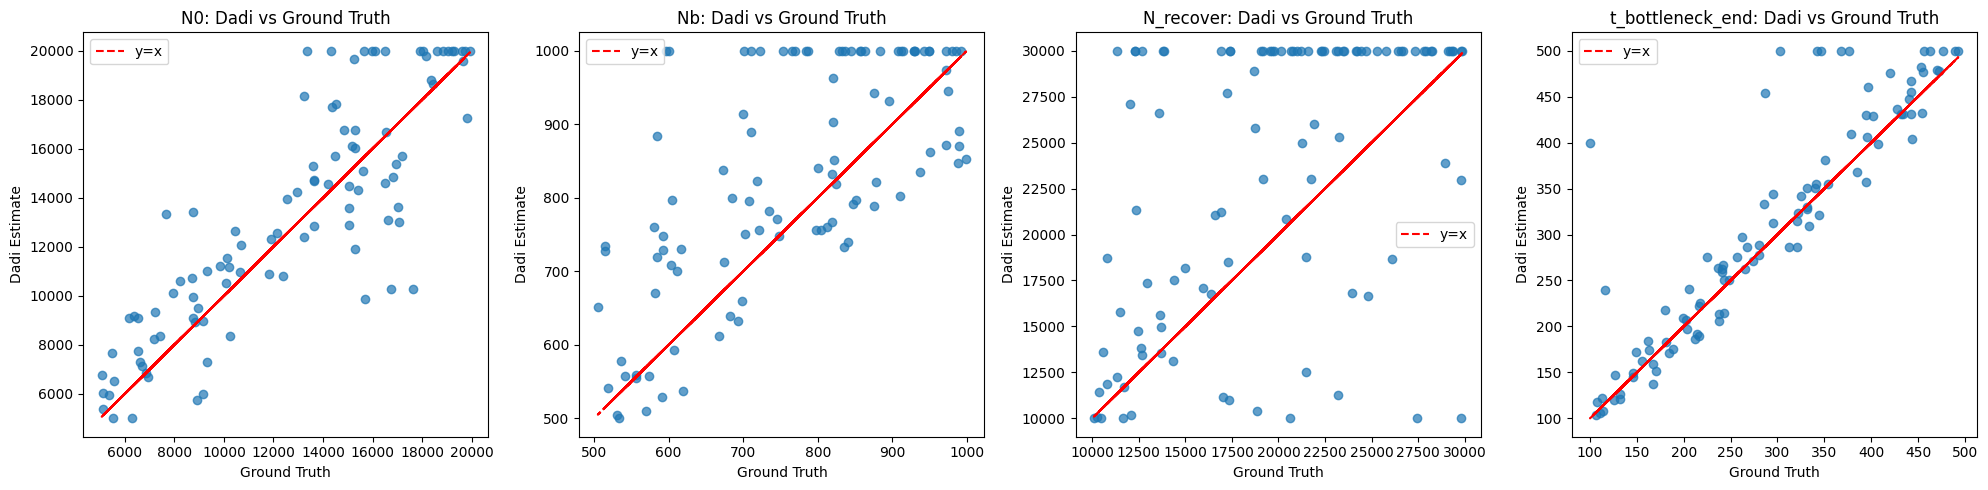

In [27]:
import os
import pickle
import matplotlib.pyplot as plt

# Directories
root_dir = "/sietch_colab/akapoor/Demographic_Inference/simulated_parameters_and_inferences"
num_sims = 100
first_replicate = 0  # Use replicate_0 for simplicity

ground_truths = []
dadi_estimates = []

for sim_number in range(num_sims):
    # Load sampled_params
    sampled_path = os.path.join(root_dir, 'simulation_results', f"sampled_params_{sim_number}.pkl")
    try:
        with open(sampled_path, "rb") as f:
            true_params = pickle.load(f)
    except Exception as e:
        print(f"Missing or broken: {sampled_path}")
        continue

    # Load dadi result
    dadi_path = os.path.join(
        root_dir,
        f"sim_{sim_number}",
        "dadi",
        f"replicate_{first_replicate}",
        f"replicate_{first_replicate}.pkl"
    )

    try:
        with open(dadi_path, "rb") as f:
            dadi_result = pickle.load(f)
            inferred_params = dadi_result.get("opt_params_dadi", {})
    except Exception as e:
        print(f"Missing or broken: {dadi_path}")
        continue

    # Exclude "ll" and "t_bottleneck_start" if present
    gt_filtered = {k: v for k, v in true_params.items() if k in inferred_params and k != "t_bottleneck_start" and k != "ll"}
    est_filtered = {k: inferred_params[k] for k in gt_filtered}

    ground_truths.append(gt_filtered)
    dadi_estimates.append(est_filtered)

# Get all parameter names (excluding 'll' and 't_bottleneck_start')
params_to_plot = ground_truths[0].keys()

# Plot
num_params = len(params_to_plot)
fig, axes = plt.subplots(1, num_params, figsize=(5 * num_params, 5))

if num_params == 1:
    axes = [axes]

for ax, param in zip(axes, params_to_plot):
    gt_vals = [d[param] for d in ground_truths]
    est_vals = [d[param] for d in dadi_estimates]

    ax.scatter(gt_vals, est_vals, alpha=0.7)
    ax.plot(gt_vals, gt_vals, 'r--', label='y=x')
    ax.set_title(f"{param}: Dadi vs Ground Truth")
    ax.set_xlabel("Ground Truth")
    ax.set_ylabel("Dadi Estimate")
    ax.legend()

plt.tight_layout()
plt.show()
